## Yield spread model with reference data


We try to use feed forward network to predict the yield spread, the input to the model is the reference data for the CUSIP

In [1]:
import pandas as pd
import numpy as np

from google.cloud import bigquery
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import shap


import plotly.graph_objects as go
from IPython.display import display, HTML

2021-07-27 18:03:08.243592: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


Setting seed for the keras layer initializer

In [2]:
layer_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1, seed=10)

Initializing the big query client

In [3]:
bq_client = bigquery.Client()

Checking if GPU is available

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2021-07-27 18:03:15.746782: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2199995000 Hz
2021-07-27 18:03:15.747136: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55abdbd865a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-07-27 18:03:15.747165: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-07-27 18:03:15.750317: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-07-27 18:03:16.527470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-27 18:03:16.528289: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55abdbd59630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-07-

True

#### Hyper-parameters for the model
The batch size and learning rate have an impact on the smoothness of convergence of the model.\
Larger the batch size the smoother the convergence. For a larger batch size we need a higher learning rate and vice-versa

In [5]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.001
BATCH_SIZE = 1000
NUM_EPOCHS = 50

SEQUENCE_LENGTH = 5
NUM_FEATURES = 8

### Query to fetch data from BigQuery

The SQL query uses the trade history with reference data view. We only use the trades which occurred after 01/01/2021. All three trade directions, namely dealer-dealer (D), dealer-sells (S), and dealer-purchases (P) are included. We are limiting the training to only tax exempt bonds which have a rating available and the yield is a positive number less than three.  


In [6]:
DATA_QUERY = """ SELECT
  rtrs_control_number,
  cusip,
  trade_datetime,
  trade_date,
  time_of_trade,
  ifnull(settlement_date, assumed_settlement_date) AS settle_date,
  maturity_date,
  coupon,
  trade_type,
  is_non_transaction_based_compensation,
  yield_spread,
  yield AS ytw,
  dollar_price AS price,
  par_traded AS quantity,
  dated_date,
  issue_price,
  interest_payment_frequency,
  par_call_date,
  next_call_price,
  par_call_price,
  previous_coupon_payment_date,
  next_coupon_payment_date,
  first_coupon_date,
  coupon_type,
  muni_security_type,
  called_redemption_type,
  refund_price,
  call_timing,
  next_call_date AS call_date,
  next_sink_date AS sink_date,
  delivery_date AS deliv_date,
  refund_date AS refund_date,
  organization_primary_name AS issuer,
  is_callable,
  is_called,
  sp_long AS sp_lt_rating,
  assumed_redemption_date,
  is_lop_or_takedown,
  incorporated_state_code,
  security_description,
  instrument_primary_name,
  is_general_obligation,
  daycount_basis_type,
  capital_type,
  use_of_proceeds
FROM
  `eng-reactor-287421.primary_views.trade_history_with_reference_data`
WHERE
  yield IS NOT NULL
  AND yield > 0 
  AND yield <= 3 
  AND par_traded IS NOT NULL
  AND sp_long IS NOT NULL
  AND sp_long != "NR"
  AND federal_tax_status = 2 --tax exempt bonds
  AND trade_date >= '2021-01-01' 
  AND msrb_valid_to_date > current_date -- condition to remove cancelled trades
ORDER BY
  trade_date DESC
            """

### Data Preparation

We grab the data from BigQuery and converts it into a format suitable for input to the model. The fetch_data function uses the big query functionality to return the data from the SQL query as a dataframe. 

In [7]:
def fetch_data(query):
    df = bq_client.query(query).result().to_dataframe()
    return df

In [8]:
%%time
if os.path.isfile('../data.pkl'):
    reference_data = pd.read_pickle('../data.pkl')
else:
    reference_data = fetch_data(DATA_QUERY)
    reference_data.to_pickle('../data.pkl')

CPU times: user 4.01 s, sys: 1.05 s, total: 5.06 s
Wall time: 5.05 s


In [9]:
reference_data.head()

,rtrs_control_number,cusip,trade_datetime,trade_date,time_of_trade,settle_date,maturity_date,coupon,trade_type,is_non_transaction_based_compensation,...,sp_lt_rating,assumed_redemption_date,is_lop_or_takedown,incorporated_state_code,security_description,instrument_primary_name,is_general_obligation,daycount_basis_type,capital_type,use_of_proceeds
0,2021071900515300,086743VJ7,2021-07-19 09:32:26,2021-07-19,09:32:26,2021-07-23,2023-07-15,4.000000000,S,False,...,AAA,2023-07-15,False,CT,BETHEL CONN,GO BDS 2021,True,3.0,6.0,9
1,2021071900236600,882723CH0,2021-07-19 08:39:23,2021-07-19,08:39:23,2021-07-21,2030-08-01,4.000000000,D,False,...,AAA,2023-08-01,False,TX,TEXAS ST WTR FINL ASSISTANT-SER B,GO WTR FIN ASSISTANCE BDS 2013 B,True,3.0,6.0,66
2,2021071900153900,894521BS1,2021-07-19 08:18:58,2021-07-19,08:18:58,2021-08-24,2029-05-01,2.000000000,D,False,...,AA,2026-05-01,False,TX,TRAVIS CNTY TEX WTR CTL & IMPT DIST NO 017 SER...,SERENE HILLS DEFINED AREA UNLTD TAX BDS 2021,True,3.0,6.0,68
3,2021071900440800,64577BL51,2021-07-19 09:23:11,2021-07-19,09:23:11,2021-07-21,2037-06-15,4.000000000,D,False,...,BBB,2027-06-15,False,NJ,NEW JERSEY ECONOMIC DEV AUTH REV SCH FACS CONS...,SCH FACS CONSTR BDS 2017 DDD,False,3.0,6.0,9
4,2021071900498400,894521AP8,2021-07-19 09:33:27,2021-07-19,09:33:27,2021-08-24,2026-05-01,2.000000000,D,False,...,AA,2026-05-01,False,TX,TRAVIS CNTY TEX WTR CTL & IMPT DIST NO 017 FLI...,UNLTD TAX BDS 2021,True,3.0,6.0,68


Used to create the categorical features for the intereset payment frequency

In [10]:
COUPON_FREQUENCY_DICT = {0:"Unknown",
                        1:"Semiannually",
                        2:"Monthly",
                        3:"Annually",
                        4:"Weekly",
                        5:"Quarterly",
                        6:"Every 2 years",
                        7:"Every 3 years",
                        8:"Every 4 years",
                        9:"Every 5 years",
                        10:"Every 7 years",
                        11:"Every 8 years",
                        12:"Biweekly",
                        13:"Changeable",
                        14:"Daily",
                        15:"Term mode",
                        16:"Interest at maturity",
                        17:"Bimonthly",
                        18:"Every 13 weeks",
                        19:"Irregular",
                        20:"Every 28 days",
                        21:"Every 35 days",
                        22:"Every 26 weeks",
                        23:"Not Applicable",
                        24:"Tied to prime",
                        25:"One time",
                        26:"Every 10 years",
                        27:"Frequency to be determined",
                        28:"Mandatory put",
                        29:"Every 52 weeks",
                        30:"When interest adjusts-commercial paper",
                        31:"Zero coupon",
                        32:"Certain years only",
                        33:"Under certain circumstances",
                        34:"Every 15 years",
                        35:"Custom",
                        36:"Single Interest Payment"
                        }

In [11]:
df = reference_data.copy()
df.interest_payment_frequency.fillna(0, inplace=True)
df.interest_payment_frequency = df.interest_payment_frequency.apply(lambda x: COUPON_FREQUENCY_DICT[x])
df.interest_payment_frequency.head()

0    Semiannually
1    Semiannually
2    Semiannually
3    Semiannually
4    Semiannually
Name: interest_payment_frequency, dtype: object

Removing trades with size less that 10,000 dollars

In [12]:
df = df[df.quantity > 10000]

Converting the columns to correct datatypes. We also restrict the universe of trades to only investment grade bonds 

In [13]:
%%time
df.quantity = np.log10(df.quantity.astype(float))
df.coupon = df.coupon.astype(float)

df['timestamp'] = pd.to_datetime(df['trade_datetime'], format='%Y-%m-%d %H:%M:%S')
df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y-%m-%d')
df['settle_date'] = pd.to_datetime(df['settle_date'], format='%Y-%m-%d')
df['maturity_date'] = pd.to_datetime(df['maturity_date'], format='%Y-%m-%d')
df['call_date'] = pd.to_datetime(df['call_date'], format='%Y-%m-%d')
df['sink_date'] = pd.to_datetime(df['sink_date'], format='%Y-%m-%d')
df['deliv_date'] = pd.to_datetime(df['deliv_date'], format='%Y-%m-%d')
df['assumed_redemption_date'] = pd.to_datetime(df['assumed_redemption_date'], format='%Y-%m-%d')
df['yield_spread'] = df['yield_spread'] * 100

#add dates from the ytw calculator for test: 
df['dated_date'] = pd.to_datetime(df['dated_date'], format='%Y-%m-%d')
df['par_call_date'] = pd.to_datetime(df['par_call_date'], format='%Y-%m-%d')
df['maturity_date'] = pd.to_datetime(df['maturity_date'], format='%Y-%m-%d')
df['previous_coupon_payment_date'] = pd.to_datetime(df['previous_coupon_payment_date'], format='%Y-%m-%d')
df['next_coupon_payment_date'] = pd.to_datetime(df['next_coupon_payment_date'], format='%Y-%m-%d')
df['first_coupon_date'] = pd.to_datetime(df['first_coupon_date'], format='%Y-%m-%d')

rd = pd.to_datetime(df['refund_date'], format='%Y-%m-%d')
rd[rd < df.trade_date] = pd.NaT
df['refund_date'] = rd
df['rating'] = df.sp_lt_rating

# Just including investment grade bonds
df = df[df.rating.isin(['A-','A','A+','AA-','AA','AA+','AAA'])] 

print(len(df))

2188593
CPU times: user 7.24 s, sys: 1.21 s, total: 8.44 s
Wall time: 8.43 s


Creating Binary features

In [14]:
df['callable'] = df.is_callable  
df['called'] = df.is_called 
df['zerocoupon'] = df.coupon == 0
df['whenissued'] = df.deliv_date >= df.trade_date
df['sinking'] = ~df.sink_date.isnull()

# if the redemption type is NA we fill it with zero i.e unknown ref ice
df.called_redemption_type.fillna(0, inplace=True)

Converting the dates to number of days from settlement date. We only consider trades to be reportedly correctly if the trades are settled within on month of the trade date. 

In [15]:
# Dropping trades settled one month after the trade
df['days_to_settle'] = (df.settle_date - df.trade_date).dt.days
df = df[df.days_to_settle <= 31]

In [16]:
df['days_to_maturity'] =  np.log10(1 + (df.assumed_redemption_date - df.settle_date).dt.days)
df['days_to_call'] = np.log10(1 + (df.call_date - df.settle_date).dt.days.fillna(0))
# df['days_to_coupon'] = np.log10(1 + (df.next_coupon_payment_date - df.settle_date).dt.days)

# # Removing trades which mature in less than a year or 
# # have a call date less than a year from settlement date 
df = df[df.days_to_maturity > np.log10(360)]
df = df[df.days_to_call > np.log10(360)]


# Removing bonds from Puerto Rico
df = df[df.incorporated_state_code != 'PR']

In [17]:
def settlement_pace(x):
    if x <= 3:
        return 'Fast'
    elif x>3 and x <=15:
        return 'Medium'
    else:
        return 'Slow'

In [18]:
df['settle_pace'] = df.days_to_settle.apply(settlement_pace)

In [19]:
df = df[~df.called]

In [21]:
# features: 
IDENTIFIERS = ['rtrs_control_number', 'cusip']
BINARY = ['callable','sinking','whenissued','zerocoupon','is_non_transaction_based_compensation','is_general_obligation']
CATEGORICAL_FEATURES = ['trade_type','rating','coupon_type', 'muni_security_type','called_redemption_type','incorporated_state_code','settle_pace','interest_payment_frequency']
NON_CAT_FEATURES = ['quantity','days_to_maturity','days_to_call','coupon',]
TARGET = ['yield_spread']

PREDICTORS = BINARY + CATEGORICAL_FEATURES + NON_CAT_FEATURES + TARGET

In [22]:
processed_data = df[IDENTIFIERS + PREDICTORS]

In [23]:
processed_data = processed_data.dropna()
len(processed_data)

1158541

In [24]:
train_index = int( len(processed_data) * (1-TRAIN_TEST_SPLIT))
print(train_index)
train_dataframe = processed_data[train_index:]
test_dataframe = processed_data[:train_index]

print(len(train_dataframe))
print(len(test_dataframe))

173781
984760
173781


In [25]:
train_dataframe.head(10)

,rtrs_control_number,cusip,callable,sinking,whenissued,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,trade_type,rating,...,muni_security_type,called_redemption_type,incorporated_state_code,settle_pace,interest_payment_frequency,quantity,days_to_maturity,days_to_call,coupon,yield_spread
404008,2021061505146700,89453PKP3,True,False,False,False,False,True,D,AAA,...,5,0.0,TX,Fast,Semiannually,4.602060,2.794488,2.794488,3.00,-47.98856
404010,2021061504671000,3735394V4,True,True,False,False,False,False,P,AAA,...,8,0.0,GA,Fast,Semiannually,5.000000,3.211921,3.211921,3.50,156.11144
404011,2021061502086000,542269CR4,True,False,False,False,False,False,D,AA,...,8,0.0,TX,Fast,Semiannually,4.301030,3.182129,3.182129,5.00,-27.68856
404012,2021061500568100,139015QP9,True,False,False,False,False,True,D,AAA,...,5,0.0,TX,Fast,Semiannually,4.176091,3.386499,3.386499,3.00,36.31144
404013,2021061500869100,416415HW0,True,False,False,False,False,True,D,AA,...,5,0.0,CT,Fast,Semiannually,5.000000,3.173186,3.173186,5.00,-29.48856
404015,2021061504813400,799387AN5,True,True,False,False,False,False,D,AA,...,10,0.0,CA,Fast,Semiannually,4.397940,3.122544,3.122544,5.00,13.51144
404016,2021061505091000,678505GT9,True,False,False,False,False,False,D,AA-,...,8,0.0,OK,Fast,Semiannually,5.000000,3.343606,3.343606,3.25,52.81144
404019,2021061500879100,34682NCQ4,True,False,True,False,False,True,D,AA,...,5,0.0,TX,Slow,Semiannually,4.698970,3.713323,3.274389,2.00,111.71144
404020,2021061501661300,69651ABL7,True,True,False,False,False,False,S,AA-,...,8,0.0,FL,Fast,Semiannually,4.397940,3.474508,3.474508,3.00,87.41144
404025,2021061505351300,882117M84,True,False,False,False,False,False,D,AAA,...,8,0.0,TX,Fast,Semiannually,5.397940,3.169086,3.169086,5.00,-49.88856


### Reference data model
Feed forward network that takes the reference data as input and predicts the yield spreads. The model also learns vector embeddings for the categorical features present in the data. 
As a pre-processing step we use a label encoder to created class embeddings for the categorical variables between 0 and n_classes-1. In future work we can try more dense embeddings.



In [40]:
for i in NON_CAT_FEATURES + BINARY:
    print(train_dataframe[i].to_numpy().astype('float64'))

[4.60205999 5.         4.30103    ... 4.54406804 4.17609126 4.39794001]
[2.79448805 3.21192108 3.18212921 ... 3.17666993 2.9498777  3.35140975]
[2.79448805 3.21192108 3.18212921 ... 3.17666993 2.9498777  3.35140975]
[3.    3.5   5.    ... 4.    3.125 4.   ]
[1. 1. 1. ... 1. 1. 1.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 1. 0.]
[1. 0. 0. ... 1. 0. 1.]


In [41]:
noncat = layers.Input(shape=(len(NON_CAT_FEATURES + BINARY),), name = "non-categorical")
inputs = []
layer = []

for i in NON_CAT_FEATURES + BINARY:
    inputs.append(layers.Input(shape=(1,), name = f"{i}"))

for i in inputs:
    layer.append(Normalization()(i))

encoders = {}
for f in CATEGORICAL_FEATURES:
    fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    fin = layers.Input(shape=(1,), name = f)
    inputs.append(fin)
    embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax+1,
                                                                    output_dim = 30,
                                                                    input_length= 1,
                                                                    name = f + "_embed",
                                                                    embeddings_initializer=layer_initializer)(fin))
    layer.append(embedded)

hidden = layers.Dense(300, activation='relu', kernel_initializer=layer_initializer)(layers.concatenate(layer))
hidden2 = layers.Dense(100, activation='tanh', kernel_initializer=layer_initializer)(hidden)
final = layers.Dense(1, activation='linear', kernel_initializer=layer_initializer)(hidden2)
model = keras.Model(inputs=inputs, outputs=final)

def create_input(df):
    datalist = []
    for f in NON_CAT_FEATURES + BINARY:
        datalist.append(df[f].to_numpy().astype('float64'))
        
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float64'))
    return datalist

In [42]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
trade_type (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
rating (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
coupon_type (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
muni_security_type (InputLayer) [(None, 1)]          0                                            
_______________________________________________________________________________________

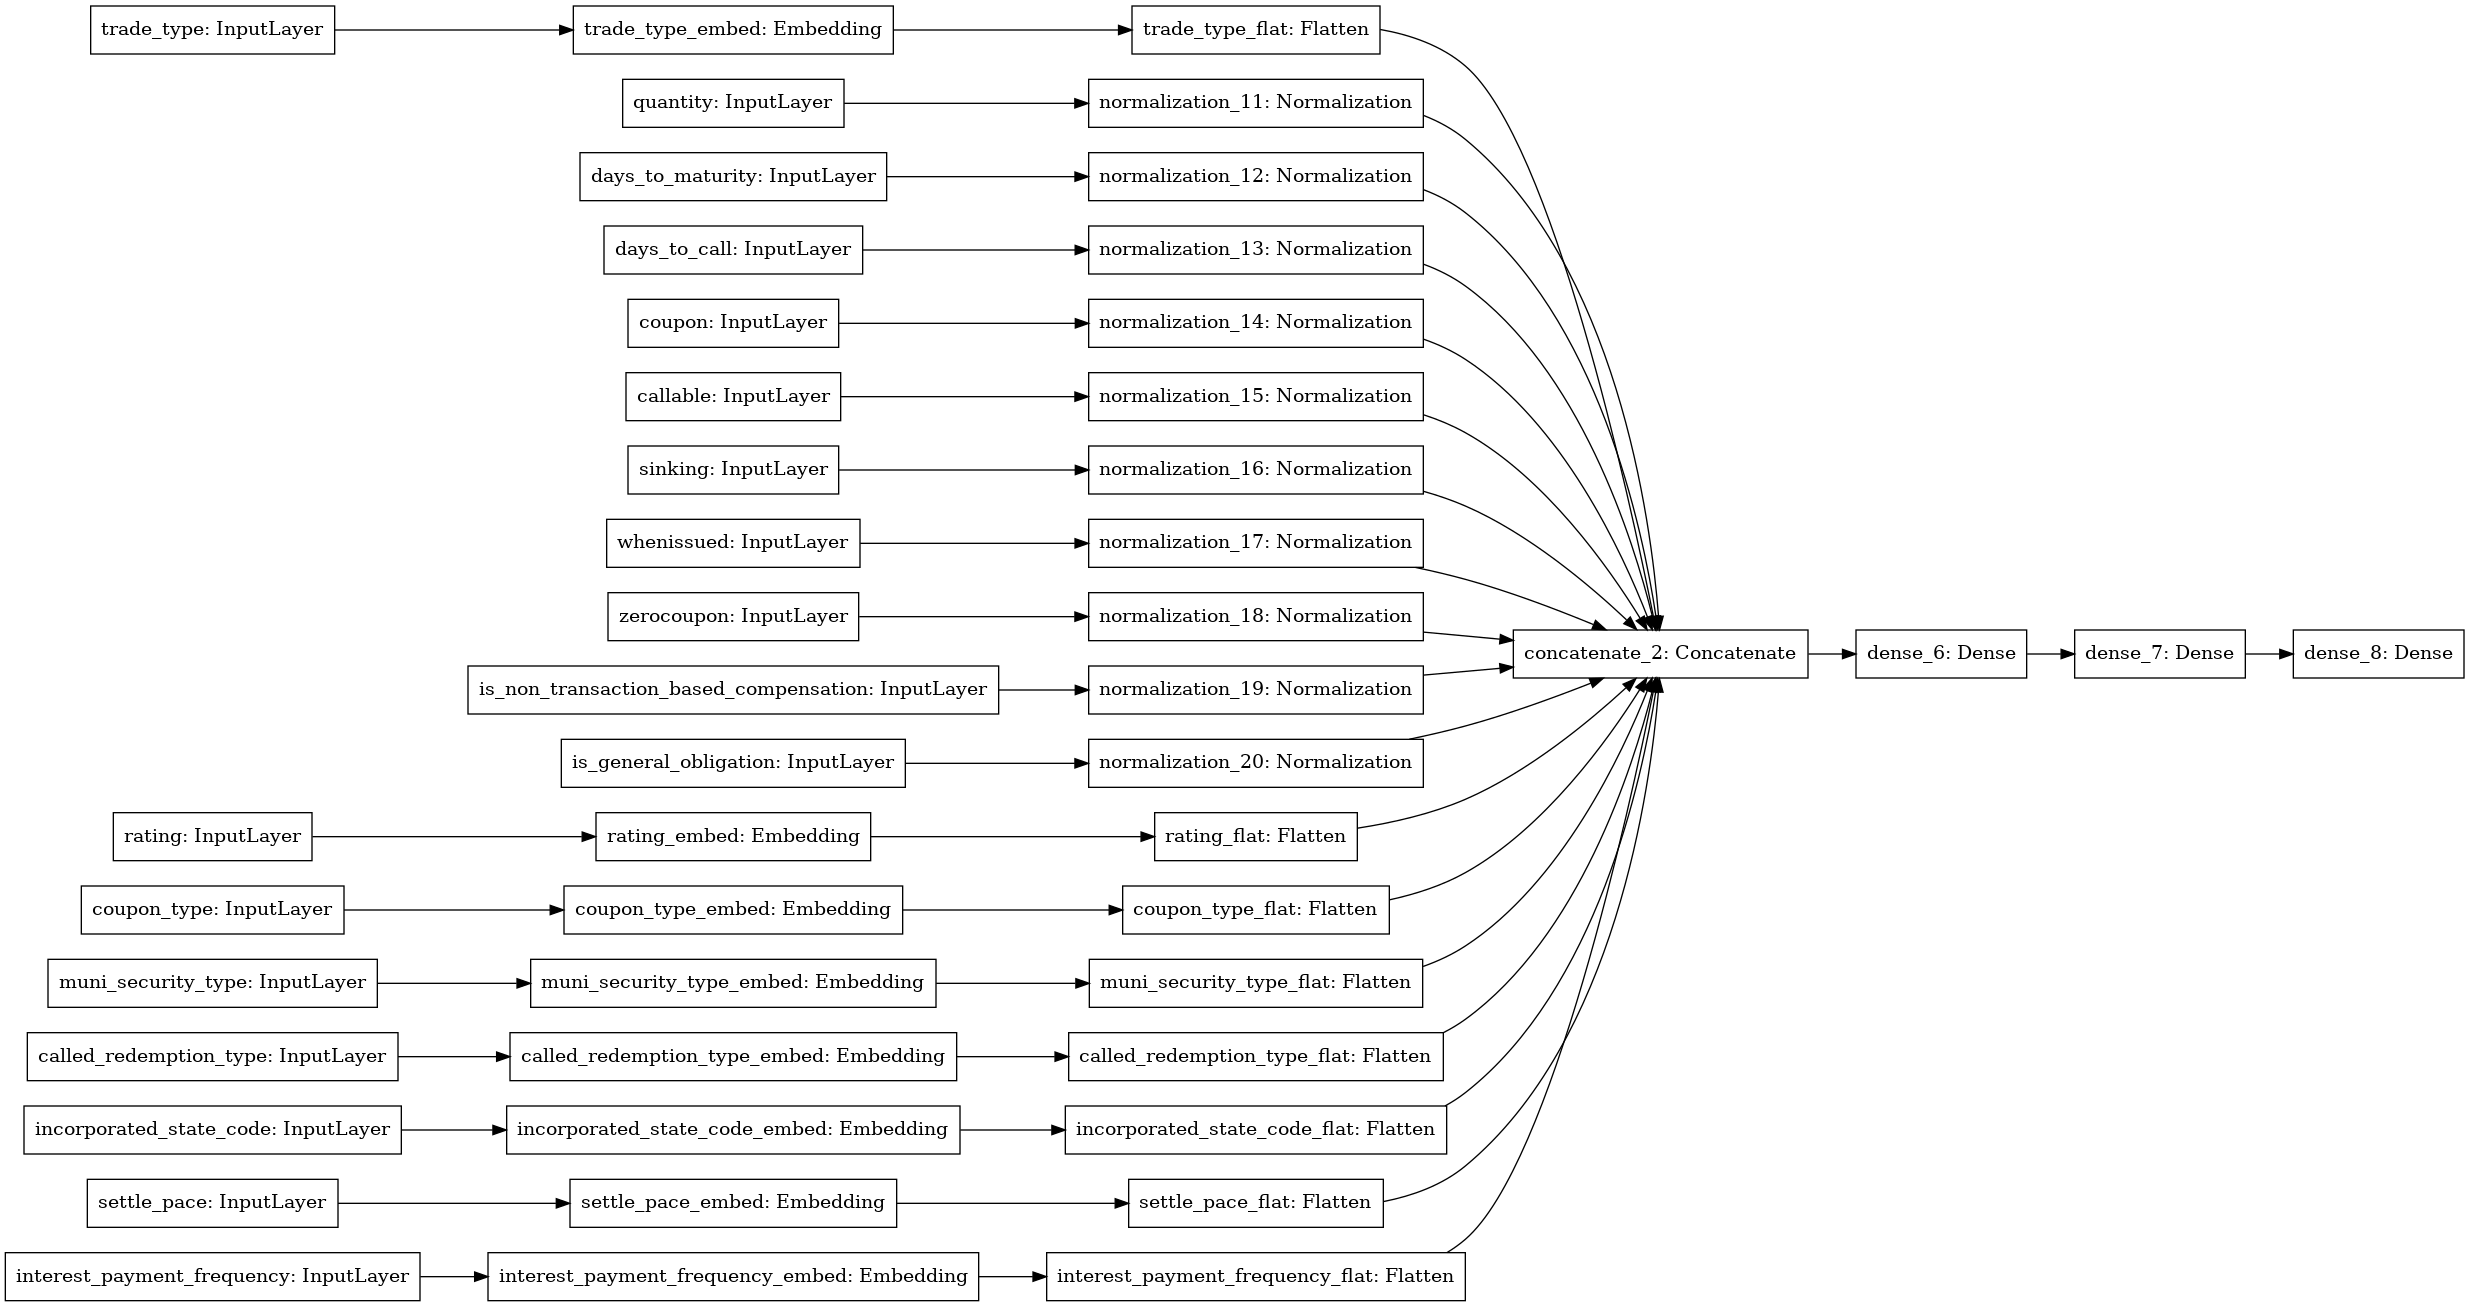

In [43]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [44]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

In [45]:
train_data = create_input(train_dataframe)
%time history = model.fit(train_data, train_dataframe.yield_spread, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_split=0.1)

Epoch 1/50


2021-07-27 18:36:23.622644: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11


887/887 [==============================] - 5s 6ms/step - loss: 1471.9850 - mean_absolute_error: 29.2064 - val_loss: 937.9154 - val_mean_absolute_error: 24.1546
Epoch 2/50
887/887 [==============================] - 5s 5ms/step - loss: 728.7314 - mean_absolute_error: 20.5188 - val_loss: 989.6061 - val_mean_absolute_error: 25.0154
Epoch 3/50
887/887 [==============================] - 5s 5ms/step - loss: 627.6552 - mean_absolute_error: 18.9169 - val_loss: 709.0376 - val_mean_absolute_error: 20.5100
Epoch 4/50
887/887 [==============================] - 5s 5ms/step - loss: 592.7551 - mean_absolute_error: 18.3215 - val_loss: 758.0092 - val_mean_absolute_error: 21.4744
Epoch 5/50
887/887 [==============================] - 5s 5ms/step - loss: 571.6403 - mean_absolute_error: 17.9585 - val_loss: 730.3434 - val_mean_absolute_error: 21.0444
Epoch 6/50
887/887 [==============================] - 5s 5ms/step - loss: 556.4360 - mean_absolute_error: 17.6850 - val_loss: 737.2482 - val_mean_absolute_error

In [46]:
_, mae = model.evaluate(create_input(test_dataframe), test_dataframe.yield_spread, verbose=1)
print(f"Test MAE: {round(mae, 3)}")

5431/5431 [==============================] - 15s 3ms/step - loss: 453.1519 - mean_absolute_error: 15.9471
Test MAE: 15.947


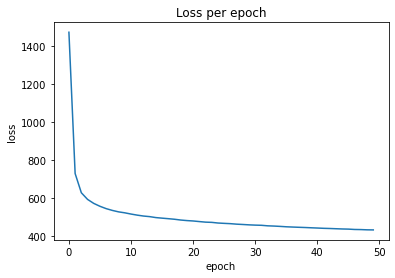

In [47]:
plt.plot(range(len(history.history['loss'])),history.history['loss'])
plt.title('Loss per epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [48]:
encarray = create_input(train_dataframe)
%time preds = model.predict(encarray)
preds = preds.reshape(len(preds))

error = train_dataframe.yield_spread - preds

CPU times: user 2min 1s, sys: 27.3 s, total: 2min 28s
Wall time: 58.8 s


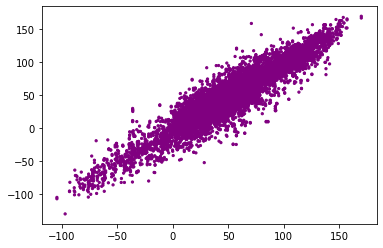

In [49]:
from matplotlib.colors import to_rgb, to_rgba
threshold = 1e6

# plot points with transparency depending on size of trade
def drawpoints(preds, target, train_dataframe):
    #Only draw Dealer-Dealer trades
    r, g, b = to_rgb('purple')
    keep = (10**train_dataframe.quantity > threshold) & (train_dataframe.trade_type == 'D')  # save time by not plotting points that would be invisible
    w = np.minimum( np.array(10**train_dataframe.quantity[keep]), threshold)
    opacity = w/threshold
    color = [(r, g, b, alpha) for alpha in opacity]
    plt.scatter(preds[keep], target[keep], s=5, c=color)
    
plt.figure()
drawpoints(preds, train_dataframe.yield_spread, train_dataframe)

In [50]:
test_preds = model.predict(create_input(test_dataframe))

In [51]:
test_dataframe.columns

Index(['rtrs_control_number', 'cusip', 'callable', 'sinking', 'whenissued',
       'zerocoupon', 'is_non_transaction_based_compensation',
       'is_general_obligation', 'trade_type', 'rating', 'coupon_type',
       'muni_security_type', 'called_redemption_type',
       'incorporated_state_code', 'settle_pace', 'interest_payment_frequency',
       'quantity', 'days_to_maturity', 'days_to_call', 'coupon',
       'yield_spread'],
      dtype='object')

In [52]:
evaluation_dataframe = test_dataframe.copy()
evaluation_dataframe['predicted_yield_spreads'] = test_preds
evaluation_dataframe['delta_yield_spreads'] = evaluation_dataframe.yield_spread - evaluation_dataframe.predicted_yield_spreads

In [53]:
evaluation_dataframe.days_to_maturity = 10**evaluation_dataframe.days_to_maturity
evaluation_dataframe.days_to_call = 10**evaluation_dataframe.days_to_call
evaluation_dataframe.quantity = 10**evaluation_dataframe.quantity
evaluation_dataframe.sort_values('delta_yield_spreads', ascending=False)

,rtrs_control_number,cusip,callable,sinking,whenissued,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,trade_type,rating,...,incorporated_state_code,settle_pace,interest_payment_frequency,quantity,days_to_maturity,days_to_call,coupon,yield_spread,predicted_yield_spreads,delta_yield_spreads
89661,2021071205541600,373539K46,True,False,False,False,False,False,D,AAA,...,GA,Fast,Semiannually,20000.0,506.0,506.0,3.90,182.811142,-16.625032,199.436175
74368,2021071205541900,373539K46,True,False,False,False,False,False,D,AAA,...,GA,Fast,Semiannually,20000.0,506.0,506.0,3.90,182.811142,-16.625032,199.436175
252933,2021062504905800,05914FQF0,True,False,False,False,False,True,P,AAA,...,MD,Medium,Semiannually,15000.0,399.0,399.0,3.00,169.071801,-6.238378,175.310179
356810,2021061703394100,802498YT6,True,False,True,False,False,True,S,AA+,...,CA,Medium,Semiannually,5000000.0,2954.0,2954.0,4.00,186.240900,21.551872,164.689028
250420,2021062504181900,64579FX57,True,False,False,False,False,False,D,AA-,...,NJ,Medium,Semiannually,15000.0,368.0,368.0,5.00,117.971801,-45.880108,163.851909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384093,2021061600988600,927676RR9,True,True,False,False,False,False,S,AA,...,VI,Fast,Semiannually,35000.0,471.0,471.0,5.00,-98.346363,19.680595,-118.026958
223222,2021062901246700,56045RVX4,True,True,False,False,False,False,D,AA+,...,ME,Fast,Semiannually,60000.0,1950.0,1950.0,4.00,24.643940,144.197098,-119.553158
27324,2021071501910200,45204EMD7,True,False,False,False,False,False,P,A,...,IL,Medium,Semiannually,40000.0,1762.0,1762.0,3.25,-4.993277,115.526619,-120.519896
220725,2021062901242900,56045RVX4,True,True,False,False,False,False,S,AA+,...,ME,Fast,Semiannually,60000.0,1950.0,1950.0,4.00,-5.956060,116.891655,-122.847715


In [54]:
temp = evaluation_dataframe[(evaluation_dataframe.delta_yield_spreads > 100) | (evaluation_dataframe.delta_yield_spreads < 100)  ]
temp.sort_values('delta_yield_spreads',ascending=False)

,rtrs_control_number,cusip,callable,sinking,whenissued,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,trade_type,rating,...,incorporated_state_code,settle_pace,interest_payment_frequency,quantity,days_to_maturity,days_to_call,coupon,yield_spread,predicted_yield_spreads,delta_yield_spreads
89661,2021071205541600,373539K46,True,False,False,False,False,False,D,AAA,...,GA,Fast,Semiannually,20000.0,506.0,506.0,3.90,182.811142,-16.625032,199.436175
74368,2021071205541900,373539K46,True,False,False,False,False,False,D,AAA,...,GA,Fast,Semiannually,20000.0,506.0,506.0,3.90,182.811142,-16.625032,199.436175
252933,2021062504905800,05914FQF0,True,False,False,False,False,True,P,AAA,...,MD,Medium,Semiannually,15000.0,399.0,399.0,3.00,169.071801,-6.238378,175.310179
356810,2021061703394100,802498YT6,True,False,True,False,False,True,S,AA+,...,CA,Medium,Semiannually,5000000.0,2954.0,2954.0,4.00,186.240900,21.551872,164.689028
250420,2021062504181900,64579FX57,True,False,False,False,False,False,D,AA-,...,NJ,Medium,Semiannually,15000.0,368.0,368.0,5.00,117.971801,-45.880108,163.851909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384093,2021061600988600,927676RR9,True,True,False,False,False,False,S,AA,...,VI,Fast,Semiannually,35000.0,471.0,471.0,5.00,-98.346363,19.680595,-118.026958
223222,2021062901246700,56045RVX4,True,True,False,False,False,False,D,AA+,...,ME,Fast,Semiannually,60000.0,1950.0,1950.0,4.00,24.643940,144.197098,-119.553158
27324,2021071501910200,45204EMD7,True,False,False,False,False,False,P,A,...,IL,Medium,Semiannually,40000.0,1762.0,1762.0,3.25,-4.993277,115.526619,-120.519896
220725,2021062901242900,56045RVX4,True,True,False,False,False,False,S,AA+,...,ME,Fast,Semiannually,60000.0,1950.0,1950.0,4.00,-5.956060,116.891655,-122.847715


In [55]:
tdf = df.copy()
tdf = tdf[tdf.rtrs_control_number == 2021071505946500]
tdf[PREDICTORS]

,callable,sinking,whenissued,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,trade_type,rating,coupon_type,muni_security_type,called_redemption_type,incorporated_state_code,settle_pace,interest_payment_frequency,quantity,days_to_maturity,days_to_call,coupon,yield_spread
19584,True,True,False,False,False,False,P,A,17,8,0.0,TX,Medium,Semiannually,4.69897,2.922206,2.922206,4.125,-22.993277


In [65]:
model.save('.')

INFO:tensorflow:Assets written to: ./assets
